This is the first example (Deterministic flexibility) in this Bansal paper https://aiche.onlinelibrary.wiley.com/doi/epdf/10.1002/aic.690460212

In [17]:
from sys import executable
from pyomo.environ import *
from pyomo.core import *
import numpy as np
import pandas as pd

from ppopt.mpmodel import MPModeler, VariableType
from ppopt.mp_solvers.solve_mpqp import solve_mpqp, mpqp_algorithm
from matplotlib import pyplot as plt
import sympy as sp

In [18]:
# range of allowable design variable values

d1 = [0, 5]
d2 = [0, 5]
d_nom = [2.5, 2.5]
d_std = [5/6,5/6]

# parameters
theta1_values = [0, 4]
theta2_values = [0, 4]
theta_nom = [2,2]
theta_std = [0.5, 0.5]

model = MPModeler()

# variables
u = model.add_var(name = 'u')
x = model.add_var(name = 'x')
z = model.add_var(name = 'z')

# uncertain parameters
theta_1 = model.add_param(name = 'theta_1')
theta_2 = model.add_param(name = 'theta_2')
d1_temp = model.add_param(name = 'd1_temp')
d2_temp = model.add_param(name = 'd2_temp')

# constraints
model.add_constr(2*x - 3*z + theta_1 - d2_temp + 50 == 0)
model.add_constr(x - 0.5*z + 25 - 0.5*theta_1 + 0.5*theta_2 + d1_temp - 3.5*d2_temp <= u)
model.add_constr(-2*x + 2*z + 151/3 - (4/3)*theta_1 - theta_2 + 2*d2_temp <= u)
model.add_constr(-x + 2.5*z - 26 + 0.5*theta_1 - theta_2 - d1_temp + 0.5*d2_temp <= u)

# bounds on uncertain parameters
model.add_constr(theta_1 >= theta1_values[0])
model.add_constr(theta_1 <= theta1_values[1])
model.add_constr(theta_2 >= theta2_values[0])
model.add_constr(theta_2 <= theta2_values[1])
model.add_constr(d1_temp >= d1[0])
model.add_constr(d1_temp <= d1[1])
model.add_constr(d2_temp >= d2[0])
model.add_constr(d2_temp <= d2[1])


model.set_objective(u-50)
prog = model.formulate_problem()
solution = solve_mpqp(prog)
region_list = solution.critical_regions


# explicit stochastic flexibility assuming normal distribution for theta and design

mean = [theta_nom[0], theta_nom[1], d_nom[0], d_nom[1]]
cov = np.diag([theta_std[0]**2, theta_std[1]**2, d_std[0]**2, d_std[1]**2])

mu_vector = []
sigma_vector = []

for region in range(len(region_list)):
    A = region_list[region].A[0,:] # the theta coeffs
    b = region_list[region].b[0] # the constant term
    mu = A@mean + b
    sigma = A@cov@A.T
    mu_vector.append(mu[0])
    sigma_vector.append(sigma)

lambda_vector = []
for region in range(len(region_list)):
    A = region_list[region].A[0,:] # the theta coeffs
    lambda_vector.append(A)

lambda_matrix = np.array(lambda_vector)

sigma_psi = lambda_matrix@cov@lambda_matrix.T

from scipy.stats import multivariate_normal

dist = multivariate_normal(mu_vector, sigma_psi)


# Evaluate the probability density function at a specific point
# Calculate the probability of a specific region
upper_bound = [0,0]
probability = dist.cdf(upper_bound)
probability

0.0

In [19]:
region_list

[Critical region with active set [0, 1, 2]
 The Omega Constraint indices are [0, 1, 2, 3, 4, 5, 6, 7]
 The Lagrange multipliers Constraint indices are []
 The Regular Constraint indices are [[0], [3]]
   x(θ) = Aθ + b 
  λ(θ) = Cθ + d 
   Eθ <= f
  A = [[-6.66666667e-01 -2.50000000e-01  5.00000000e-01 -1.00000000e+00]
  [-2.71684799e-16 -1.12500000e+00 -7.50000000e-01  3.50000000e+00]
  [ 3.33333333e-01 -7.50000000e-01 -5.00000000e-01  2.00000000e+00]] 
  b = [[50.16666667]
  [50.25      ]
  [50.16666667]] 
  C = [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]] 
  d = [[0.96824584]
  [2.        ]
  [1.98606255]] 
  E = [[ 0.45584231 -0.34188173 -0.45584231  0.68376346]
  [-1.          0.          0.          0.        ]
  [ 1.          0.          0.          0.        ]
  [ 0.         -1.          0.          0.        ]
  [ 0.          1.          0.          0.        ]
  [ 0.          0.         -1.          0.        ]
  [ 0.          0.          1.          0.        ]
  [ 0.     

In [15]:
# case: fixed design value

d1 = [0, 5]
d2 = [0, 5]

model = MPModeler()

# parameters
theta1_values = [0, 4]
theta2_values = [0, 4]
theta_nom = [2,2]
theta_std = [0.5, 0.5]

# temporary design variables
d1_temp = min(d1)
d2_temp = max(d2)

# design capacity
d1_cap = 1
d2_cap = 1

# variables
u = model.add_var(name = 'u')
x = model.add_var(name = 'x')
z = model.add_var(name = 'z')

# uncertain parameters
theta_1 = model.add_param(name = 'theta_1')
theta_2 = model.add_param(name = 'theta_2')

# constraints
model.add_constr(2*x - 3*z + theta_1 - d1_cap*d1_temp - 50 == 0)
model.add_constr(x - 0.5*z + 25 - 0.5*theta_1 + 0.5*theta_2 + d1_cap*d1_temp - 3.5*d2_temp*d2_cap <= u)
model.add_constr(-2*x + 2*z + 1/3 - (4/3)*theta_1 - theta_2 + 2*d2_temp*d2_cap <= u)
model.add_constr(-x + 2.5*z + 74 + 0.5*theta_1 - theta_2 - d1_cap*d1_temp + 0.5*d2_temp*d2_cap <= u)

# bounds on uncertain parameters
model.add_constr(theta_1 >= theta1_values[0])
model.add_constr(theta_1 <= theta1_values[1])
model.add_constr(theta_2 >= theta2_values[0])
model.add_constr(theta_2 <= theta2_values[1])

model.set_objective(u)
prog = model.formulate_problem()
solution = solve_mpqp(prog)
region_list = solution.critical_regions
# building flex matrix u = [delta, design variables, constants]

parameters = len(model.parameters) # number of uncertain parameters

# explicit stochastic flexibility assuming normal distribution for theta and design

mean = [theta_nom[0], theta_nom[1]]
cov = np.diag([theta_std[0]**2, theta_std[1]**2])

mu_vector = []
sigma_vector = []

for region in range(len(region_list)):
    A = region_list[region].A[0,:] # the theta coeffs
    b = region_list[region].b[0] # the constant term
    mu = A@mean + b
    sigma = A@cov@A.T
    mu_vector.append(mu[0])
    sigma_vector.append(sigma)

lambda_vector = []
for region in range(len(region_list)):
    A = region_list[region].A[0,:] # the theta coeffs
    lambda_vector.append(A)

lambda_matrix = np.array(lambda_vector)

sigma_psi = lambda_matrix@cov@lambda_matrix.T

from scipy.stats import multivariate_normal

dist = multivariate_normal(mu_vector, sigma_psi)


# Evaluate the probability density function at a specific point
# Calculate the probability of a specific region
upper_bound = [0,0]
probability = dist.cdf(upper_bound)

print('The stochastic flexibility index is {} given d1 = {}, d2 = {}'.format(probability, d1_temp, d2_temp))

The stochastic flexibility index is [1.71495623e-18 1.71495623e-18] given d1 = 0, d2 = 5


In [16]:
print(region_list)

[Critical region with active set [0, 1, 2]
The Omega Constraint indices are [0, 1, 2, 3]
The Lagrange multipliers Constraint indices are []
The Regular Constraint indices are [[], []]
  x(θ) = Aθ + b 
 λ(θ) = Cθ + d 
  Eθ <= f
 A = [[ 3.33333333e-01 -1.00000000e+00]
 [-1.50000000e+00 -2.89077034e-16]
 [-6.66666667e-01 -3.49793428e-16]] 
 b = [[  5.91666667]
 [-43.375     ]
 [-45.58333333]] 
 C = [[0. 0.]
 [0. 0.]
 [0. 0.]] 
 d = [[2.80624304]
 [1.71593836]
 [1.5411035 ]] 
 E = [[-1.  0.]
 [ 1.  0.]
 [ 0. -1.]
 [ 0.  1.]] 
 f = [[-0.]
 [ 4.]
 [-0.]
 [ 4.]]]


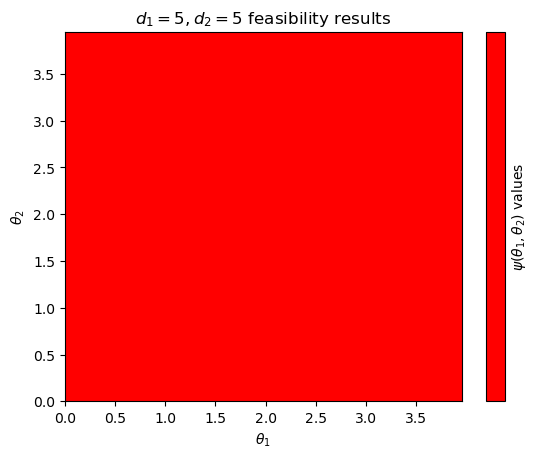

In [8]:
def f(x,y):
    return solution.evaluate_objective(np.array([x,y]).reshape(-1,1))

x = y = np.arange(0, 4, 0.05)
X, Y = np.meshgrid(x, y)

zs = np.array([f(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(len(x), len(y))

from matplotlib.colors import ListedColormap, BoundaryNorm
colors = ['blue', 'white', 'red']
cmap = ListedColormap(colors)

bounds = [-np.inf, 0, np.inf]
norm = BoundaryNorm(bounds, cmap.N)

contour = plt.contourf(X, Y, Z, levels=100, cmap=cmap, norm=norm)
cbar = plt.colorbar(contour, ticks=[-1,0,1])
cbar.set_label(r'$\psi(\theta_1, \theta_2)$ values')


plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title(r'$d_1 = 5, d_2 = 5$ feasibility results')
plt.show()

IndexError: list index out of range

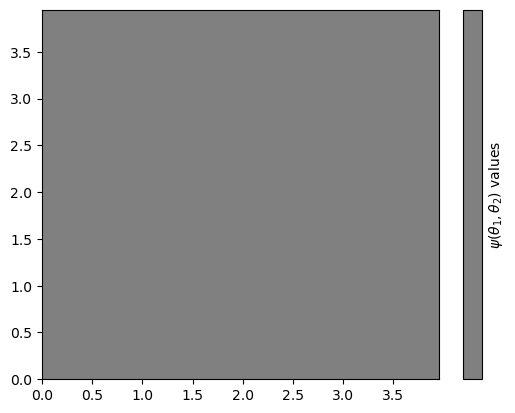

In [10]:
from matplotlib.patheffects import PathPatchEffect, SimpleLineShadow, Normal


# plot feasible vs not feasible
def f(x,y):
    return solution.evaluate_objective(np.array([x,y]).reshape(-1,1))

x_val = y_val = np.arange(0, 4, 0.05)
X, Y = np.meshgrid(x_val, y_val)

zs = np.array([f(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(len(x_val), len(y_val))

from matplotlib.colors import ListedColormap, BoundaryNorm
colors = ['white', 'white', 'gray']
cmap = ListedColormap(colors)

bounds = [-np.inf, 0, np.inf]
norm = BoundaryNorm(bounds, cmap.N)

contour = plt.contourf(X, Y, Z, levels=100, cmap=cmap, norm=norm)
cbar = plt.colorbar(contour, ticks=[-1,0,1])
cbar.set_label(r'$\psi(\theta_1, \theta_2)$ values')

# plot chi(theta) as lines

x, y = sp.symbols('x y')
chi1 = region_list[-1].A[0][0]*x + region_list[-1].A[0][1]*y + region_list[-1].b[0][0]
lim1 = region_list[-1].E[0][0]*x + region_list[-1].E[0][1]*y - region_list[-1].f[0][0]

y_expr = sp.solve(chi1, y)[0]
f_y = sp.lambdify(x, y_expr, 'numpy')
y_vals = f_y(x_val)

y_lim = sp.solve(lim1, y)[0]
f_y_lim = sp.lambdify(x, y_lim, 'numpy')
y_lim_val = f_y_lim(x_val)

plt.plot(x_val, y_vals, color = 'green',path_effects=[SimpleLineShadow(shadow_color="green", linewidth=10),Normal()])
plt.plot(x_val, y_lim_val, color = 'red', path_effects=[SimpleLineShadow(offset = (-2,2),shadow_color="red", linewidth=10),Normal()])

# # fill where the critical region is NOT. So everything is >= 0, which is why we're plotting a max
# plt.fill_between(x_val, 0, y_vals, color='blue', alpha=0.3)
# plt.fill_between(x_val, y_lim_val, 4, color='red', alpha=0.3)


# plot distribution
from scipy.stats import multivariate_normal

mu_x, mu_y = 2, 2
sigma_x, sigma_y = 0.5, 0.5

x1 = y1 = np.linspace(0, 4, 100)
X1, Y1 = np.meshgrid(x1,y1)

pos = np.dstack((X1, Y1))
Z1 = multivariate_normal.pdf(pos, mean = [mu_x, mu_y], cov = [[sigma_x**2, 0], [0, sigma_y**2]])

contour2 = plt.contour(X1,Y1,Z1,levels = 5)
plt.xlim(0,4)
plt.ylim(0,4)
plt.xlabel(r'$\theta_1$')
plt.ylabel(r'$\theta_2$')
plt.title(r'$d_1 = 5, d_2 = 5$ with 50% capacity disruption')
plt.show()

In [11]:
mean = [mu_x, mu_y]
cov = [[sigma_x**2, 0], [0, sigma_y**2]]

mu_vector = []
sigma_vector = []

for region in range(len(region_list)):
    A = region_list[region].A[0,:] # the theta coeffs
    b = region_list[region].b[0] # the constant term
    mu = A@mean + b
    sigma = A@cov@A.T
    mu_vector.append(mu[0])
    sigma_vector.append(sigma)

NameError: name 'mu_x' is not defined

In [ ]:
lambda_vector = []
for region in range(len(region_list)):
    A = region_list[region].A[0,:] # the theta coeffs
    lambda_vector.append(A)

lambda_matrix = np.array(lambda_vector)

sigma_psi = lambda_matrix@cov@lambda_matrix.T

In [ ]:
from scipy.stats import multivariate_normal

dist = multivariate_normal(mu_vector, sigma_psi)


# Evaluate the probability density function at a specific point
# Calculate the probability of a specific region
upper_bound = [0,0]
probability = dist.cdf(upper_bound)
probability